# Text Classification Notebook

This notebook contains: EDA, preprocessing, model building (3 models), hyperparameter tuning, evaluation, and a minimal deployment scaffold.

In [1]:
# Set NLTK_DATA to a local directory and download resources there
import os
import nltk
nltk_data_dir = os.path.join(os.getcwd(), 'nltk_data')
os.environ['NLTK_DATA'] = nltk_data_dir
os.makedirs(nltk_data_dir, exist_ok=True)
for res in ['punkt', 'wordnet', 'omw-1.4', 'stopwords']:
    nltk.download(res, download_dir=nltk_data_dir)
print('NLTK resources downloaded to', nltk_data_dir)

[nltk_data] Downloading package punkt to c:\All
[nltk_data]     Assignments\NLP\NLP_Assignment\nlp-
[nltk_data]     assignment\classifier\notebooks\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to c:\All
[nltk_data]     Assignments\NLP\NLP_Assignment\nlp-
[nltk_data]     assignment\classifier\notebooks\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to c:\All
[nltk_data]     Assignments\NLP\NLP_Assignment\nlp-
[nltk_data]     assignment\classifier\notebooks\nltk_data...


NLTK resources downloaded to c:\All Assignments\NLP\NLP_Assignment\nlp-assignment\classifier\notebooks\nltk_data


[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to c:\All
[nltk_data]     Assignments\NLP\NLP_Assignment\nlp-
[nltk_data]     assignment\classifier\notebooks\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 1. Imports and setup
import os, re, string, math, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import joblib

# For NLP preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

print('Imports done')

Imports done


In [3]:
# --- CELL 3: CORRECTED DATA PREP (Fixes Title Leakage) ---
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import os

# 1. Load Data
BASE_PATH = r'C:\All Assignments\NLP\NLP_Assignment\nlp-assignment\classifier\data\raw'
fake_path = os.path.join(BASE_PATH, "fake.csv")
true_path = os.path.join(BASE_PATH, "true.csv")

try:
    df_fake = pd.read_csv(fake_path)
    df_true = pd.read_csv(true_path)
    print("Datasets loaded successfully.")
except FileNotFoundError:
    print("ERROR: Files not found. Check BASE_PATH.")

# 2. Add Labels
df_fake['target'] = 0
df_true['target'] = 1

# 3. Merge & Shuffle
df = pd.concat([df_fake, df_true], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

# 4. Combine Title + Text FIRST
df['text_data'] = df['title'] + " " + df['text']

# 5. Define The Cleaning Function
def clean_text_aggressive(text):
    text = str(text)
    # Remove "Reuters" header and mentions
    text = re.sub(r"^.*?\(Reuters\) - ", "", text)
    text = re.sub(r"\bReuters\b", "", text, flags=re.IGNORECASE)
    # Remove Clickbait Artifacts (from titles too)
    artifacts = r"\b(video|watch|image|pic|featured|breaking|hillary|getty|wow|just|via)\b"
    text = re.sub(artifacts, "", text, flags=re.IGNORECASE)
    return text

# 6. Apply Cleaning to the COMBINED text
print("Applying aggressive cleaning to Titles AND Body...")
df['text_data'] = df['text_data'].apply(clean_text_aggressive)

# 7. Trim Length (Optimization)
df['text_data'] = df['text_data'].astype(str).str[:1000]

# 8. Split
X_train, X_test, y_train, y_test = train_test_split(
    df['text_data'],
    df['target'],
    test_size=0.2,
    random_state=42,
    stratify=df['target']
    )

print(f"Data Cleaned. Training Shape: {X_train.shape}")
print("-" * 50)
print("Sample cleaned text (First 100 chars):")
print(df['text_data'].iloc[0][:100])

Datasets loaded successfully.
Applying aggressive cleaning to Titles AND Body...
Data Cleaned. Training Shape: (35918,)
--------------------------------------------------
Sample cleaned text (First 100 chars):
Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution 21st Centu
Data Cleaned. Training Shape: (35918,)
--------------------------------------------------
Sample cleaned text (First 100 chars):
Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution 21st Centu


In [4]:
# Remove duplicate rows before train-test split (use correct columns after cleaning)
df = df.drop_duplicates(subset=['text_data', 'target']).reset_index(drop=True)
print('Shape after removing duplicates:', df.shape)

Shape after removing duplicates: (39090, 6)



--- Class Distribution ---


,count
label_name,
REAL,21184
FAKE,17906


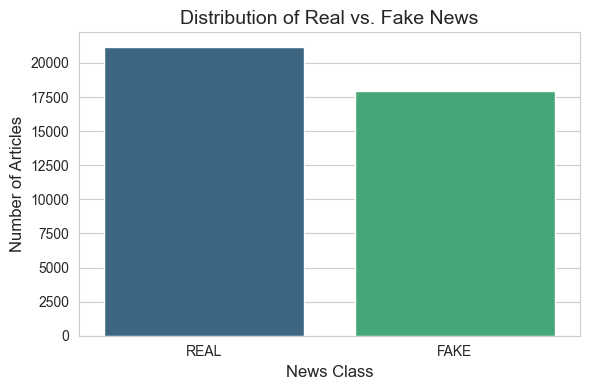


--- Article Length Analysis ---


,count,mean,std,min,25%,50%,75%,max
label_name,,,,,,,,
FAKE,17906.0,920.914498,228.352381,30.0,1000.0,1000.0,1000.0,1000.0
REAL,21184.0,881.266239,218.675208,32.0,886.0,1000.0,1000.0,1000.0


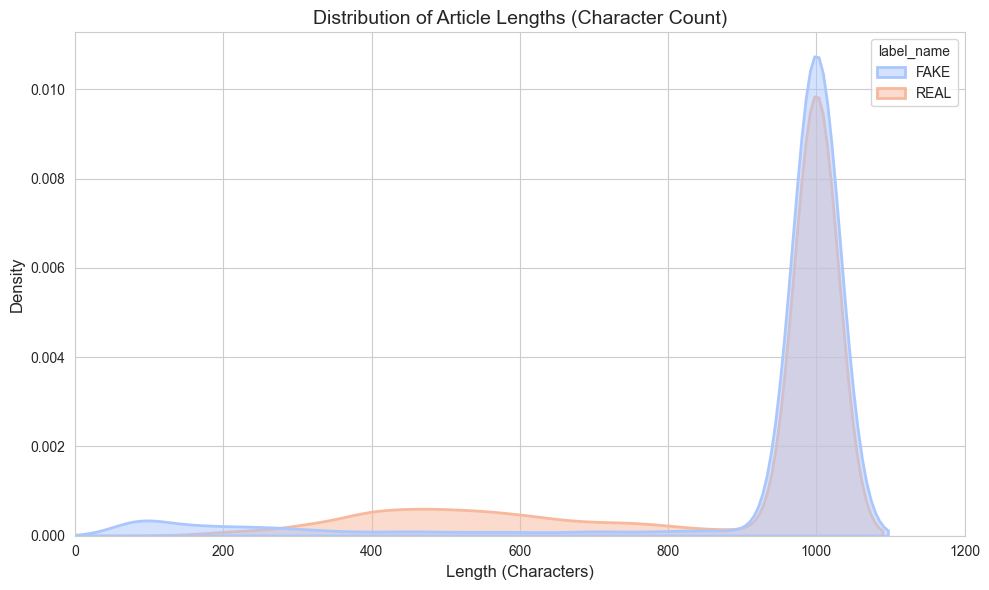


--- Word Clouds by Class ---


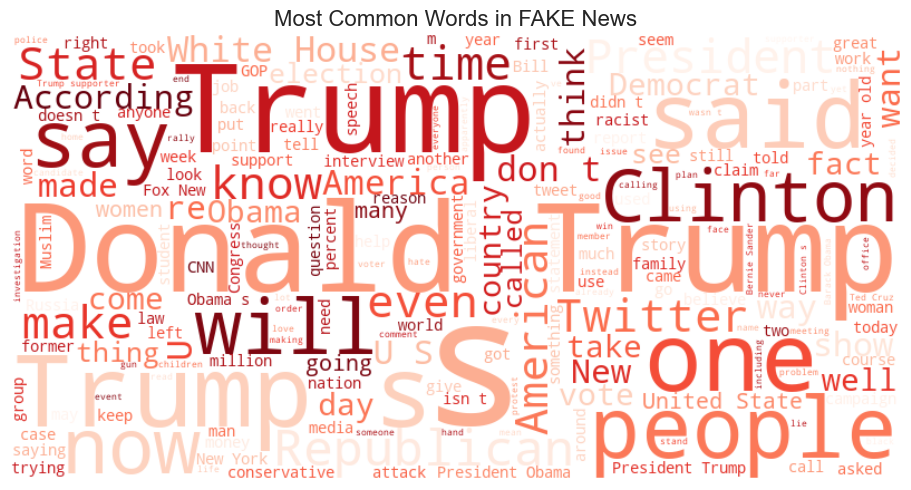

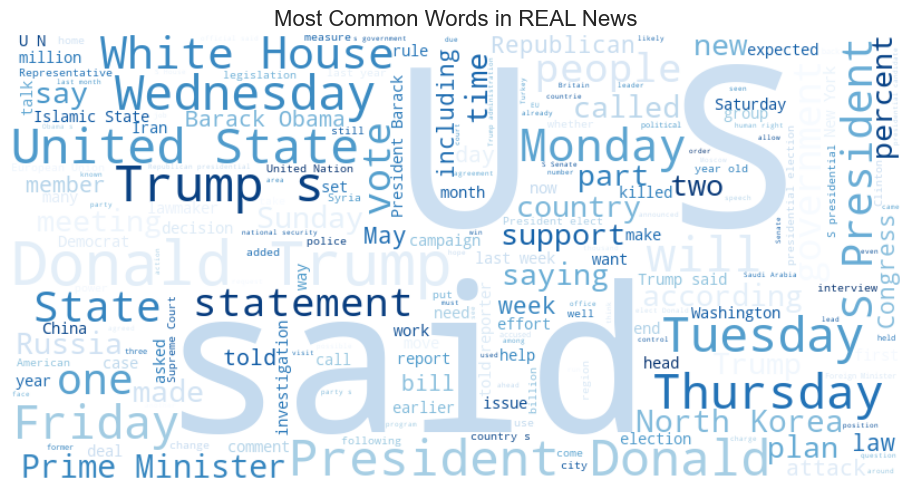


--- Top 10 Key Terms by Class (TF-IDF) ---


Word,Importance Score
trump,1204.93
president,409.76
obama,402.66
donald,381.80
clinton,363.64
people,318.44
said,310.24
white,261.04
like,245.98
new,245.68


Word,Importance Score
said,913.65
trump,884.73
president,579.48
house,424.54
state,419.36
republican,381.31
government,362.80
donald,362.12
united,337.64
new,330.58


In [5]:
# 3. Enhanced EDA (Beautiful, Organized Output)
import sys
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML, clear_output

# --- 1. Quiet Installation ---
# Check if wordcloud is installed; if not, install it quietly
try:
    import wordcloud
except ImportError:
    print("Installing wordcloud...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud", "-q"])
    print("Installation Complete.")
    clear_output() # Wipes the install logs

from wordcloud import WordCloud

# --- 2. Setup Visuals ---
sns.set_style("whitegrid")
# Map 0 -> FAKE, 1 -> REAL for display
class_labels = {0: 'FAKE', 1: 'REAL'}
df['label_name'] = df['target'].map(class_labels)

# --- 3. Label Distribution ---
print('\n--- Class Distribution ---')
label_counts = df['label_name'].value_counts()

# Display Table
display(HTML(label_counts.to_frame().to_html()))

# Plot (Fixed Warning: Added hue and legend=False)
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette='viridis', legend=False)
plt.title('Distribution of Real vs. Fake News', fontsize=14)
plt.xlabel('News Class', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.tight_layout()
plt.show()

# --- 4. Text Length Distribution ---
print('\n--- Article Length Analysis ---')
df['text_len'] = df['text_data'].astype(str).apply(len)

# Display Stats Table
stats = df.groupby('label_name')['text_len'].describe()
display(HTML(stats.to_html()))

# Plot (Improved: Separate KDEs for clarity)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='text_len', hue='label_name', fill=True, common_norm=False, palette='coolwarm', alpha=0.5, linewidth=2)
plt.title('Distribution of Article Lengths (Character Count)', fontsize=14)
plt.xlabel('Length (Characters)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlim(0, 1200) # Limit x-axis to 1200 since we trimmed to 1000
plt.tight_layout()
plt.show()

# --- 5. Word Clouds ---
print('\n--- Word Clouds by Class ---')
for label_code, label_text in class_labels.items():
    text = ' '.join(df[df['target'] == label_code]['text_data'].astype(str))
    # Custom colormap: Reds for Fake, Blues for Real
    cmap = 'Reds' if label_text == 'FAKE' else 'Blues'
    
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=cmap).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Common Words in {label_text} News', fontsize=16)
    plt.tight_layout()
    plt.show()

# --- 6. Top Words Table (Fixed Visibility) ---
from sklearn.feature_extraction.text import TfidfVectorizer

def top_tfidf_words(corpus, n=10):
    vec = TfidfVectorizer(stop_words='english', max_features=5000)
    X = vec.fit_transform(corpus)
    sums = np.asarray(X.sum(axis=0)).ravel()
    terms = vec.get_feature_names_out()
    top_terms = sorted(list(zip(terms, sums)), key=lambda x: x[1], reverse=True)[:n]
    return top_terms

print('\n--- Top 10 Key Terms by Class (TF-IDF) ---')
for label_code, label_text in class_labels.items():
    top_words = top_tfidf_words(df[df['target'] == label_code]['text_data'])
    
    # Color-coded headers: Red for Fake, Blue for Real
    header_color = '#d9534f' if label_text == 'FAKE' else '#5bc0de'
    
    # Create a Styled HTML table
    html = f"""
    <div style="float: left; margin-right: 20px; margin-bottom: 20px;">
        <h4 style="font-family: sans-serif;">Top Words for <b>{label_text}</b></h4>
        <table style="border-collapse: collapse; width: 300px; font-family: sans-serif; font-size: 14px;">
            <thead>
                <tr style="background-color: {header_color}; color: white; text-align: left;">
                    <th style="padding: 10px; border: 1px solid #ddd;">Word</th>
                    <th style="padding: 10px; border: 1px solid #ddd;">Importance Score</th>
                </tr>
            </thead>
            <tbody>
    """
    
    for i, (word, score) in enumerate(top_words):
        bg_color = "#f9f9f9" if i % 2 == 0 else "#ffffff" # Zebra striping
        html += f"""
            <tr style="background-color: {bg_color}; color: black;">
                <td style="padding: 8px; border: 1px solid #ddd;"><b>{word}</b></td>
                <td style="padding: 8px; border: 1px solid #ddd;">{score:.2f}</td>
            </tr>
        """
    
    html += """
            </tbody>
        </table>
    </div>
    """
    display(HTML(html))

Computing Sentiment & Readability Scores...

--- Sentiment & Readability Summary ---

--- Sentiment & Readability Summary ---


,Mean Sentiment,Avg Word Len,Avg Sent Len
label_name,,,
FAKE,-0.140,4.719,34.550
REAL,0.015,5.006,27.529


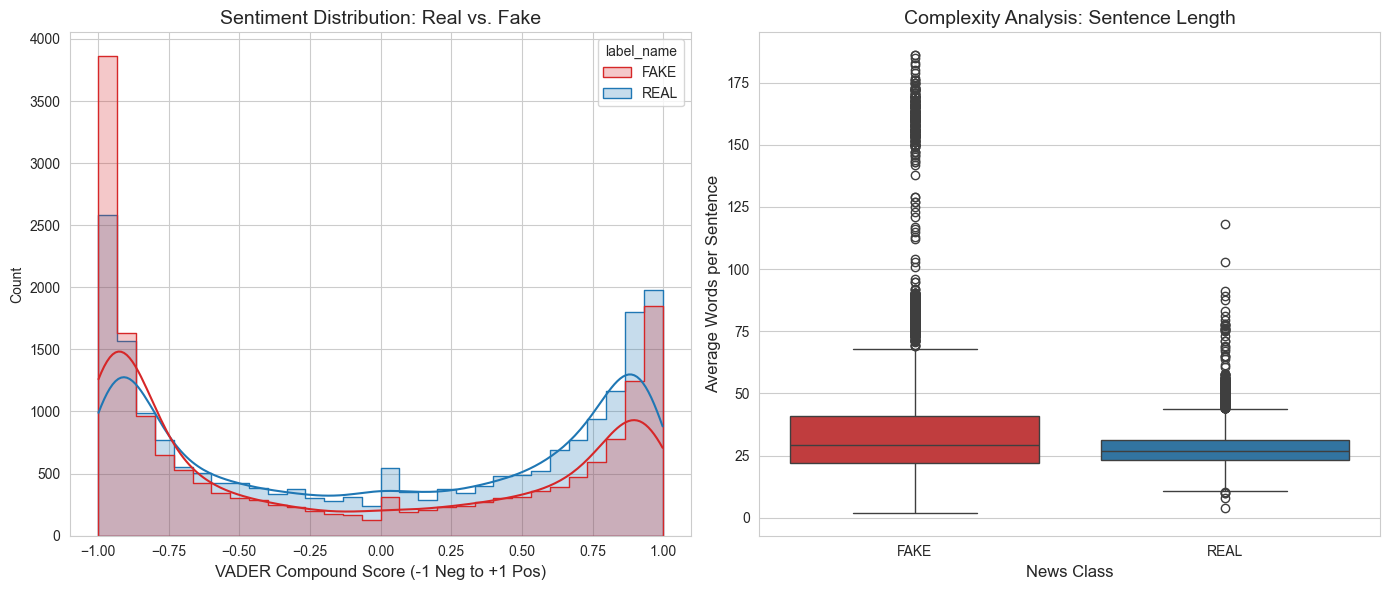


--- Top 5 REAL Examples (Most Positive) ---


,title,vader_compound,text_data
22397,"Chinese fans prepare to welcome rich, powerful, 'free-spirit' Trump",0.9978,"He may be a divisive figure back home, but U.S. President Donald Trump will be landing in friendly territory when he arrives in Beijing on Wednesday, judging by Chinese social media. On platforms such..."
24920,Trump's golf buddy Norman pitches Australia to lead diplomatic line,0.9966,"Australian Prime Minister Malcolm Turnbull became one of the first world leaders to speak to U.S. President-elect Donald Trump this week, but only after one of Trump’s old golfing buddies was asked to..."
227,"In first visit, Trump urges reform so U.N. can meet full potential",0.9955,"U.S. President Donald Trump criticized the United Nations for bloated bureaucracy and mismanagement on his first visit on Monday to U.N. headquarters, calling for truly bold reforms so it could be a..."
34271,"In first visit, Trump urges reform so U.N. can meet full potential",0.9951,"U.S. President Donald Trump criticized the United Nations for bloated bureaucracy and mismanagement on his first visit on Monday to U.N. headquarters, calling for “truly bold reforms” so it could be a..."
20450,Reaction to Prince Harry's engagement to Meghan Markle,0.9948,"Britain s Prince Harry is engaged to his U.S. actress girlfriend Meghan Markle with the marriage due to take place in the spring of 2018, his father Prince Charles announced in a statement on Monday. ..."



--- Top 5 REAL Examples (Most Negative) ---


,title,vader_compound,text_data
20346,UK terrorism arrests soar to record level after attacks this year,-0.9966,The number of people arrested in Britain on suspicion of terrorism offences rocketed by 68 percent in the last year to the highest figure on record during a period when the country suffered four deadl...
18808,"South Koreans practice in case of North Korea attack, but with little urgency",-0.9959,"Traffic was halted, movie screenings interrupted and hundreds of thousands of people across South Korea were directed to underground shelters on Wednesday as part of a civil defense drill to practice ..."
38814,Victims of South Sudan attack on aid workers start testifying from U.S.,-0.9959,Foreign victims of an attack on aid workers in South Sudan began giving testimony link from the United States on Wednesday in the trial of government soldiers accused of murder and gang rape. The as...
21178,Danish submarine owner admits dismembering body of Swedish journalist: police,-0.9958,"Danish inventor Peter Madsen has admitted to dismembering Swedish journalist Kim Wall on board his submarine in August and dumping her body parts in the sea, but he still denies killing her, police sa..."
11958,Man arrested trying to climb wall at UK's Buckingham Palace,-0.9957,"British police on Monday said they had arrested a man who tried to climb a wall at Queen Elizabeth s Buckingham Palace home in central London, but said that the incident was not terrorism-related. Th..."



--- Top 5 FAKE Examples (Most Positive) ---


,title,vader_compound,text_data
2737,FILMMAKER DINESH D’SOUZA: Eight Things I LOVE About America!,0.9968,"FILMMAKER DINESH D’SOUZA: Eight Things I LOVE About America! FILMMAKER DINESH D SOUZA S Eight things I LOVE about America! To make us love our country, Edmund Burke once said, our country ought to ..."
37308,MELANIA TRUMP Proves ‘Dressing Well Is The Best Revenge’ To Designers Who Wouldn’t Dress Her,0.9960,"MELANIA TRUMP Proves ‘Dressing Well Is The Best Revenge’ To Designers Who Wouldn’t Dress Her If you weren t convinced of the fabulousness of First Lady Melania Trump before her 9-day foreign trip, you..."
28777,OUCH! PRESIDENT TRUMP’S Call to Troops Zings Obama’s Terrible Strategy Defeating ISIS [Video],0.9958,OUCH! PRESIDENT TRUMP’S Call to Troops Zings Obama’s Terrible Strategy Defeating ISIS [] President Trump called the branches of the Armed Forces this morning to wish everyone a Happy Thanksgiving. He...
2722,RESPECT! STUDENTS BRAVE POURING RAIN To Take Down American Flag,0.9955,RESPECT! STUDENTS BRAVE POURING RAIN To Take Down American Flag Patriotism is alive and well at this Florida school!COOPERGATE SCHOOL S FACEBOOK PAGE HAS A STATEMENT ON WHAT TWO YOUNG PATRIOTS DID: Th...
31842,RAMBO LOVES “THE DONALD”: Hollywood Icon Expresses His Support For Trump As Liberal Heads Explode,0.9953,RAMBO LOVES “THE DONALD”: Hollywood Icon Expresses His Support For Trump As Liberal Heads Explode Hollywood Icon And Superstar Sylvester Stallone gave an interview with Variety to pump his latest proj...



--- Top 5 FAKE Examples (Most Negative) ---


,title,vader_compound,text_data
19428,"BREAKING! TERROR ATTACK BY SUICIDE BOMBER At Ariana Grande Concert: 19 Dead, 50 Injured…Panicked, Bloodied Kids Seen Stampeding Out Of Stadium [VIDEO]",-0.9982,"! TERROR ATTACK BY SUICIDE BOMBER At Ariana Grande Concert: 19 Dead, 50 Injured…Panicked, Bloodied Kids Seen Stampeding Out Of Stadium [] At least 19 people have been killed after explosions were hear..."
21169,Fox Host: Don’t Ban Assault Weapons Because Terrorists Would Just Use Crock Pots (VIDEO),-0.9978,Fox Host: Don’t Ban Assault Weapons Because Terrorists Would Use Crock Pots () Fox News host Tucker Carlson is so desperate to defend assault weapons that he accidentally made the case for why they ...
38314,WATCH: Trump Insults Poland By Downplaying The Horrors They Experienced During World War II,-0.9977,": Trump Insults Poland By Downplaying The Horrors They Experienced During World War II Six million Poles lost their lives during World War II. But to Donald Trump, that s tough. Perhaps no nation s..."
9658,KASICH WANTS AMNESTY FOR ILLEGALS BUT A GRIEVING MOTHER RESPONDS: “Visit the grave of my murdered child”,-0.9975,"KASICH WANTS AMNESTY FOR ILLEGALS BUT A GRIEVING MOTHER RESPONDS: “Visit the grave of my murdered child” The many, many murders and rapes of American citizens at the hands of people who re here illega..."
18937,"There WAS A Terror Attack In Sweden Recently, But Trump Won’t Like Who The Terrorists Were",-0.9975,"There WAS A Terror Attack In Sweden Recently, But Trump Won’t Like Who The Terrorists Were Trump drew international attention again by claiming there was a terror attack in Sweden on the night of Feb..."


In [6]:
# --- CELL: Enhanced Sentiment & Readability Analysis ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize
from IPython.display import display, HTML

# 1. Setup VADER
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()

# 2. Compute Metrics
print("Computing Sentiment & Readability Scores...")

# VADER Compound Score
df['vader_compound'] = df['text_data'].astype(str).apply(lambda t: sia.polarity_scores(t)['compound'])

# Readability Functions
def avg_word_length(text):
    tokens = word_tokenize(str(text))
    words = [w for w in tokens if w.isalpha()]
    return float(np.mean([len(w) for w in words])) if words else 0.0

def avg_sentence_length(text):
    sents = sent_tokenize(str(text))
    if not sents: return 0.0
    # Simple word count per sentence
    sent_lens = [len(s.split()) for s in sents] 
    return float(np.mean(sent_lens))

df['avg_word_len'] = df['text_data'].apply(avg_word_length)
df['avg_sent_len'] = df['text_data'].apply(avg_sentence_length)

# 3. Summary Statistics Table (Styled)
summary = df.groupby('label_name')[['vader_compound', 'avg_word_len', 'avg_sent_len']].mean()
summary.columns = ['Mean Sentiment', 'Avg Word Len', 'Avg Sent Len']

print("\n--- Sentiment & Readability Summary ---")
# Display as a color-coded table (Red=Low, Green=High)
display(summary.style.background_gradient(cmap='RdYlGn', subset=['Mean Sentiment'])
               .format("{:.3f}"))

# 4. Improved Visualizations
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot A: Sentiment Distribution (Histogram + KDE)
sns.histplot(data=df, x='vader_compound', hue='label_name', bins=30, kde=True, 
             palette={'REAL': 'tab:blue', 'FAKE': 'tab:red'}, element="step", ax=axes[0])
axes[0].set_title('Sentiment Distribution: Real vs. Fake', fontsize=14)
axes[0].set_xlabel('VADER Compound Score (-1 Neg to +1 Pos)', fontsize=12)

# Plot B: Sentence Length (Boxplot)
sns.boxplot(data=df, x='label_name', y='avg_sent_len', hue='label_name', 
            palette={'REAL': 'tab:blue', 'FAKE': 'tab:red'}, legend=False, ax=axes[1])
axes[1].set_title('Complexity Analysis: Sentence Length', fontsize=14)
axes[1].set_ylabel('Average Words per Sentence', fontsize=12)
axes[1].set_xlabel('News Class', fontsize=12)

plt.tight_layout()
plt.show()

# 5. Top Examples (Styled Tables)
def display_examples(label_name, sort_ascending=False, title_color='black'):
    # Filter and Sort
    subset = df[df['label_name'] == label_name].sort_values('vader_compound', ascending=sort_ascending).head(5)
    subset = subset[['title', 'vader_compound', 'text_data']]
    
    # Truncate text for display
    subset['text_data'] = subset['text_data'].str[:200] + "..."
    
    # Style the table
    print(f"\n--- Top 5 {label_name} Examples ({'Most Negative' if sort_ascending else 'Most Positive'}) ---")
    styled = subset.style.set_properties(**{'text-align': 'left'})\
        .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])\
        .background_gradient(cmap='RdYlGn', subset=['vader_compound'], vmin=-1, vmax=1)\
        .format({'vader_compound': "{:.4f}"})
    
    display(styled)

# Show Tables
display_examples('REAL', sort_ascending=False) # Real Positive
display_examples('REAL', sort_ascending=True)  # Real Negative
display_examples('FAKE', sort_ascending=False) # Fake Positive
display_examples('FAKE', sort_ascending=True)  # Fake Negative


In [7]:
# 5. Top N-Grams Analysis (Side-by-Side Comparison)
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display, HTML
import sys
import os
import numpy as np

# Ensure preprocessor is importable
sys.path.append(os.getcwd())
from preprocessor import preprocess

# Create 'proc_text' if missing (Preprocessed text for N-gram analysis)
if 'proc_text' not in df.columns:
    print("Preprocessing text for N-gram analysis (this might take a moment)...")
    df['proc_text'] = df['text_data'].apply(preprocess)

def get_top_ngrams(corpus, n=10, ngram_range=(1,1)):
    vec = TfidfVectorizer(ngram_range=ngram_range, stop_words='english', max_features=5000)
    X = vec.fit_transform(corpus)
    sums = np.asarray(X.sum(axis=0)).ravel()
    terms = vec.get_feature_names_out()
    # Sort by score descending
    top_indices = np.argsort(sums)[::-1][:n]
    return [(terms[i], sums[i]) for i in top_indices]

def display_ngram_panel(ngram_type, real_ngrams, fake_ngrams):
    # Colors
    real_color = "#5bc0de" # Blue
    fake_color = "#d9534f" # Red
    
    html = f"""
    <div style="display: flex; gap: 30px; margin-bottom: 40px; align-items: flex-start;">
        <div>
            <h4 style="font-family: sans-serif; margin-bottom: 10px;">Top {ngram_type} for <b style="color: {real_color}">REAL</b> News</h4>
            <table style="border-collapse: collapse; width: 300px; font-family: sans-serif; font-size: 14px; box-shadow: 2px 2px 5px rgba(0,0,0,0.1);">
                <thead>
                    <tr style="background-color: {real_color}; color: white; text-align: left;">
                        <th style="padding: 10px; border: 1px solid #ddd;">N-gram</th>
                        <th style="padding: 10px; border: 1px solid #ddd;">Score</th>
                    </tr>
                </thead>
                <tbody>
    """
    for i, (word, score) in enumerate(real_ngrams):
        bg = "#f9f9f9" if i % 2 == 0 else "#ffffff"
        html += f"<tr style='background-color: {bg}; color: black;'><td style='padding: 8px; border: 1px solid #ddd;'><b>{word}</b></td><td style='padding: 8px; border: 1px solid #ddd;'>{score:.2f}</td></tr>"
    
    html += f"""
                </tbody>
            </table>
        </div>
        
        <div>
            <h4 style="font-family: sans-serif; margin-bottom: 10px;">Top {ngram_type} for <b style="color: {fake_color}">FAKE</b> News</h4>
            <table style="border-collapse: collapse; width: 300px; font-family: sans-serif; font-size: 14px; box-shadow: 2px 2px 5px rgba(0,0,0,0.1);">
                <thead>
                    <tr style="background-color: {fake_color}; color: white; text-align: left;">
                        <th style="padding: 10px; border: 1px solid #ddd;">N-gram</th>
                        <th style="padding: 10px; border: 1px solid #ddd;">Score</th>
                    </tr>
                </thead>
                <tbody>
    """
    for i, (word, score) in enumerate(fake_ngrams):
        bg = "#f9f9f9" if i % 2 == 0 else "#ffffff"
        html += f"<tr style='background-color: {bg}; color: black;'><td style='padding: 8px; border: 1px solid #ddd;'><b>{word}</b></td><td style='padding: 8px; border: 1px solid #ddd;'>{score:.2f}</td></tr>"

    html += """
                </tbody>
            </table>
        </div>
    </div>
    """
    display(HTML(html))

# --- Execution ---
print("Generating N-gram Tables...")

# 1. Unigrams
real_uni = get_top_ngrams(df[df['target']==1]['proc_text'], n=10, ngram_range=(1,1))
fake_uni = get_top_ngrams(df[df['target']==0]['proc_text'], n=10, ngram_range=(1,1))
display_ngram_panel("Unigrams (Single Words)", real_uni, fake_uni)

# 2. Bigrams
real_bi = get_top_ngrams(df[df['target']==1]['proc_text'], n=10, ngram_range=(2,2))
fake_bi = get_top_ngrams(df[df['target']==0]['proc_text'], n=10, ngram_range=(2,2))
display_ngram_panel("Bigrams (Pairs)", real_bi, fake_bi)

Preprocessing text for N-gram analysis (this might take a moment)...
Generating N-gram Tables...
Generating N-gram Tables...


N-gram,Score
said,922.50
trump,892.50
state,579.65
president,565.15
republican,470.05
house,432.98
government,372.80
donald,366.92
party,356.07
united,341.20


N-gram,Score
donald trump,604.25
united state,490.80
president donald,452.65
white house,438.83
prime minister,337.26
north korea,317.56
said statement,275.40
barack obama,228.90
official said,222.57
told reporter,221.90


In [8]:
# 6. Train-Test Split & Preprocessing Verification (High Contrast Fix)
import pandas as pd
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
import os

# Ensure path is correct for import
sys.path.append(os.getcwd())
from preprocessor import TextPreprocessor

# --- 1. Perform Split ---
X = df['text_data']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# --- 2. Verify Preprocessing Effects ---
sample_idx = 0
raw_sample = X_train.iloc[sample_idx]

# Apply the transformation
preprocessor = TextPreprocessor()
clean_sample_list = preprocessor.transform([raw_sample]) 
clean_sample = clean_sample_list[0]

# Escaping HTML characters for safety
raw_sample_safe = raw_sample.replace("<", "&lt;").replace(">", "&gt;")
clean_sample_safe = clean_sample.replace("<", "&lt;").replace(">", "&gt;")

# --- 3. Generate "Before & After" Card (High Contrast CSS) ---
html_comparison = f"""
<div style="border: 1px solid #d1d5db; border-radius: 8px; padding: 20px; background-color: #ffffff; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h3 style="margin-top: 0; color: #111827; border-bottom: 2px solid #3b82f6; padding-bottom: 10px; font-family: sans-serif;">🧪 Preprocessing Verification</h3>
    
    <div style="display: flex; gap: 20px; margin-bottom: 20px;">
        <div style="flex: 1;">
            <h4 style="color: #dc2626; text-transform: uppercase; font-size: 0.9em; margin-bottom: 5px; font-family: sans-serif;">🔴 Before (Raw Text)</h4>
            <div style="background-color: #fef2f2; padding: 12px; border: 1px solid #fca5a5; border-radius: 4px; 
                        font-family: 'Courier New', monospace; font-size: 0.9em; height: 150px; overflow-y: auto; 
                        color: #000000; line-height: 1.5;">
                {raw_sample_safe}
            </div>
        </div>
        
        <div style="flex: 1;">
            <h4 style="color: #059669; text-transform: uppercase; font-size: 0.9em; margin-bottom: 5px; font-family: sans-serif;">🟢 After (Cleaned & Normalized)</h4>
            <div style="background-color: #ecfdf5; padding: 12px; border: 1px solid #6ee7b7; border-radius: 4px; 
                        font-family: 'Courier New', monospace; font-size: 0.9em; height: 150px; overflow-y: auto; 
                        color: #000000; line-height: 1.5;">
                {clean_sample_safe}
            </div>
        </div>
    </div>
    
    <div style="background-color: #f3f4f6; padding: 12px; border-radius: 4px; font-size: 0.95em; color: #1f2937; border: 1px solid #e5e7eb;">
        <b>ℹ️ Transformation Check:</b> 
        Original Length: <b>{len(raw_sample)}</b> chars | 
        Cleaned Length: <b>{len(clean_sample)}</b> chars
    </div>
</div>
"""
display(HTML(html_comparison))

# --- 4. Verify Vectorization (TF-IDF) ---
print("\n🔍 TF-IDF Vectorization Test (Top 10 Features)...")
vectorizer = TfidfVectorizer(max_features=10, stop_words='english')
X_sample_vec = vectorizer.fit_transform(clean_sample_list)

# Create a clean DataFrame for the vector
df_vec = pd.DataFrame(
    X_sample_vec.toarray(), 
    columns=vectorizer.get_feature_names_out(),
    index=["Sample 1"]
)

# Style the vector table - Forcing black text
# Note: We use set_properties to override any notebook theme defaults
styled_vec = df_vec.style.background_gradient(cmap='Blues', axis=1)\
                   .format("{:.4f}")\
                   .set_properties(**{'color': 'black', 'background-color': 'white', 'border-color': '#e5e7eb'})

display(styled_vec)

print(f"\n✅ Train Shape: {X_train.shape} | Test Shape: {X_test.shape}")


🔍 TF-IDF Vectorization Test (Top 10 Features)...


,called,conservative,john,kelli,mccain,pac,republican,rino,support,ward
Sample 1,0.0928,0.4642,0.2785,0.3714,0.3714,0.2785,0.3714,0.1857,0.1857,0.3714



✅ Train Shape: (31272,) | Test Shape: (7818,)



--- 1. Quick Model Validation (3-Fold CV) ---
Sanity Check Accuracy: 0.9734 (+/- 0.0018)
✅ STATUS: Pipeline is robust. Proceeding to Interpretation.

--- 2. Generating LIME Explanation for Report ---
Sanity Check Accuracy: 0.9734 (+/- 0.0018)
✅ STATUS: Pipeline is robust. Proceeding to Interpretation.

--- 2. Generating LIME Explanation for Report ---
Explaining Test Sample #0
True Label: 0 (0=Fake, 1=Real)
Text snippet:  GOP Senator Says Flynn Stonewalling Russia Investigation According to Senate Intelligence Committee chairman Richard Burr (R-N.C.), Michael Flynn is not willing to cooperate with the committee s inve...
Explaining Test Sample #0
True Label: 0 (0=Fake, 1=Real)
Text snippet:  GOP Senator Says Flynn Stonewalling Russia Investigation According to Senate Intelligence Committee chairman Richard Burr (R-N.C.), Michael Flynn is not willing to cooperate with the committee s inve...


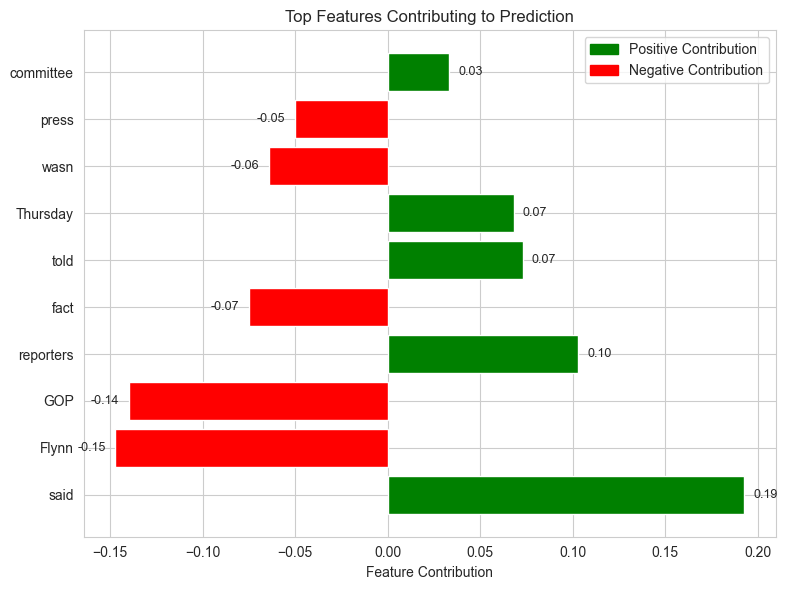

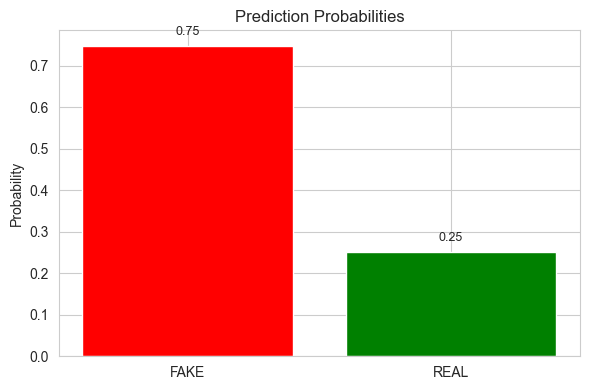

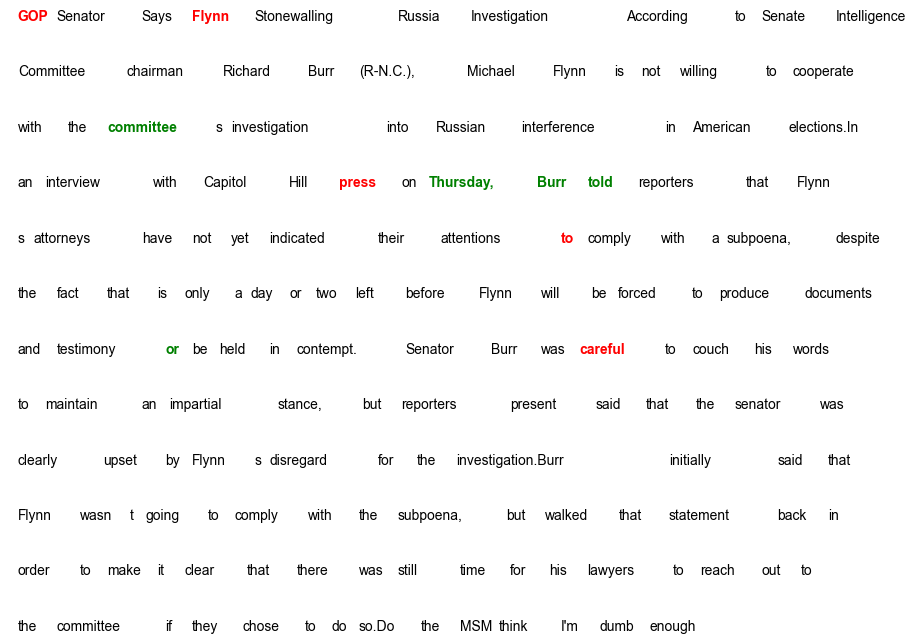

In [9]:
# --- CELL: Quick Validation & Model Interpretability (LIME) ---
# 1. Install LIME if missing
try:
    import lime
except ImportError:
    print("Installing LIME...")
    !pip install lime
    import lime

from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from matplotlib import patches
from textwrap import wrap

# --- PART 1: Quick Sanity Check (Option D) ---
print("\n--- 1. Quick Model Validation (3-Fold CV) ---")
# We use a simple Logistic Regression pipeline for this test
# It's fast and supports predict_proba (needed for LIME)
debug_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# Run fast CV
scores = cross_val_score(debug_pipeline, X_train, y_train, cv=3, scoring='accuracy')
print(f"Sanity Check Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

if scores.mean() > 0.95:
    print("✅ STATUS: Pipeline is robust. Proceeding to Interpretation.")
else:
    print("⚠️ WARNING: Accuracy dropped. Check preprocessing changes.")

# --- PART 2: Interpretability with LIME (Custom Visualization) ---
print("\n--- 2. Generating LIME Explanation for Report ---")

# Fit the model on full training data
debug_pipeline.fit(X_train, y_train)

# Create the Explainer
explainer = LimeTextExplainer(class_names=['FAKE', 'REAL'])

# Pick a specific FAKE news sample from the test set to explain
# We look for a prediction that is '0' (Fake)
fake_indices = [i for i, x in enumerate(y_test) if x == 0]
idx_to_explain = fake_indices[0] # Pick the first one
sample_text = X_test.iloc[idx_to_explain]
true_label = y_test.iloc[idx_to_explain]

print(f"Explaining Test Sample #{idx_to_explain}")
print(f"True Label: {true_label} (0=Fake, 1=Real)")
print(f"Text snippet: {sample_text[:200]}...")

# Generate Explanation
# We pass the raw text -> pipeline's predict_proba
exp = explainer.explain_instance(
    sample_text, 
    debug_pipeline.predict_proba, 
    num_features=10
    )

# Custom Visualization
# Bar Chart for Feature Importance
fig, ax = plt.subplots(figsize=(8, 6))
feature_names = [x[0] for x in exp.as_list()]
feature_scores = [x[1] for x in exp.as_list()]
colors = ['green' if score > 0 else 'red' for score in feature_scores]

bars = ax.barh(feature_names, feature_scores, color=colors)
ax.set_xlabel('Feature Contribution')
ax.set_title('Top Features Contributing to Prediction')

# Adjust numeric labels closer to the bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.005 if width > 0 else width - 0.005, 
            bar.get_y() + bar.get_height() / 2, 
            f'{width:.2f}', 
            ha='left' if width > 0 else 'right', 
            va='center', 
            fontsize=9)

# Move legend to the top right corner
legend_patches = [patches.Patch(color='green', label='Positive Contribution'),
                  patches.Patch(color='red', label='Negative Contribution')]
ax.legend(handles=legend_patches, loc='upper right')

plt.tight_layout()
plt.show()

# Probability Visualization
probs = debug_pipeline.predict_proba([sample_text])[0]
fig, ax = plt.subplots(figsize=(6, 4))
class_names = ['FAKE', 'REAL']
bars = ax.bar(class_names, probs, color=['red', 'green'])
ax.set_ylabel('Probability')
ax.set_title('Prediction Probabilities')

# Add numeric labels to each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, 
            height + 0.02, 
            f'{height:.2f}', 
            ha='center', 
            va='bottom', 
            fontsize=9)

plt.tight_layout()
plt.show()

# Highlight Entire Paragraph with Important Words (Remove Horizontal Empty Lines)
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

# Split the text into words and highlight based on weights
words = sample_text.split()
highlight_map = {word_index: weight for word_index, weight in exp.as_map()[1]}

# Wrap the text into multiple lines
wrapped_lines = []
current_line = []
current_length = 0
for i, word in enumerate(words):
    weight = highlight_map.get(i, 0)  # Default weight is 0 if not in the map
    color = 'green' if weight > 0 else 'red' if weight < 0 else 'black'
    current_line.append((word, color))
    current_length += len(word) + 1
    if current_length > 80:  # Wrap after 80 characters
        wrapped_lines.append(current_line)
        current_line = []
        current_length = 0
if current_line:
    wrapped_lines.append(current_line)

# Render the wrapped text with highlights
line_height = 0.12  # Further reduce line height to remove empty space
for line_idx, line in enumerate(wrapped_lines):
    x_offset = 0.01
    for word, color in line:
        ax.text(x_offset, 1 - line_idx * line_height, word, fontsize=10, color=color, ha='left', va='center', weight='bold' if color != 'black' else 'normal')
        x_offset += len(word) * 0.015 + 0.005  # Adjust word spacing for better fit

plt.show()

In [10]:
# --- Data Integrity & Quality Assurance Report (Fixed CSS) ---
import pandas as pd
from IPython.display import display, HTML

print("\nRunning Data Integrity Checks...")

# 1. Check for Overlap (Data Leakage)
overlap = set(X_train) & set(X_test)
overlap_count = len(overlap)
overlap_status = "✅ PASSED" if overlap_count == 0 else "❌ FAILED"
overlap_bg = "#d4edda" if overlap_count == 0 else "#f8d7da" # Green vs Red background
overlap_text = "#155724" if overlap_count == 0 else "#721c24" # Dark Green vs Dark Red text

# 2. Check for Duplicates
dup_stats = pd.DataFrame([
    ['Full Dataset', df.duplicated(subset=['text_data', 'target']).sum()],
    ['Training Set', pd.Series(X_train).duplicated().sum()],
    ['Test Set', pd.Series(X_test).duplicated().sum()]
], columns=['Dataset', 'Duplicate Count'])

# 3. Check Class Balance
train_dist = y_train.value_counts().sort_index()
test_dist = y_test.value_counts().sort_index()

dist_df = pd.DataFrame({
    'Train Count': train_dist,
    'Train %': (train_dist / len(y_train) * 100).round(2),
    'Test Count': test_dist,
    'Test %': (test_dist / len(y_test) * 100).round(2)
})
dist_df.index = dist_df.index.map({0: 'FAKE', 1: 'REAL'})

# --- STYLE DEFINITIONS (Percent signs escaped with %%) ---
table_style = """
<style>
    .audit-table { width: 100%%; border-collapse: collapse; margin-bottom: 15px; font-family: sans-serif; }
    .audit-table th { background-color: #e9ecef; color: #495057; padding: 8px; text-align: left; border-bottom: 2px solid #dee2e6; }
    .audit-table td { padding: 8px; border-bottom: 1px solid #dee2e6; color: #212529; }
    .audit-card { border: 1px solid #dee2e6; border-radius: 8px; padding: 20px; background-color: #ffffff; box-shadow: 0 2px 4px rgba(0,0,0,0.05); }
    .audit-header { margin-top: 0; color: #2c3e50; border-bottom: 2px solid #007bff; padding-bottom: 10px; margin-bottom: 20px; }
    .audit-section { margin-bottom: 25px; }
    .audit-label { font-size: 14px; font-weight: bold; color: #6c757d; text-transform: uppercase; margin-bottom: 8px; display: block; }
    .status-badge { background-color: %s; color: %s; padding: 5px 10px; border-radius: 4px; font-weight: bold; border: 1px solid %s; }
</style>
""" % (overlap_bg, overlap_text, overlap_text)

# --- GENERATE REPORT HTML ---
dup_html = dup_stats.to_html(index=False, classes='audit-table', border=0)
dist_html = dist_df.to_html(classes='audit-table', border=0)

report_html = f"""
{table_style}
<div class="audit-card">
    <h2 class="audit-header">🛡️ Data Integrity Audit Report</h2>
    
    <div class="audit-section">
        <span class="audit-label">1. Data Leakage Check (Train-Test Overlap)</span>
        <div style="background-color: {overlap_bg}; padding: 10px; border-radius: 5px; border: 1px solid {overlap_text}; color: {overlap_text};">
            <span style="font-size: 1.2em; margin-right: 10px;">{overlap_status}</span>
            <span>Found <b>{overlap_count}</b> overlapping samples between Training and Testing sets.</span>
        </div>
    </div>

    <div style="display: flex; gap: 20px; flex-wrap: wrap;">
        <div style="flex: 1; min-width: 300px;">
            <span class="audit-label">2. Duplicate Analysis</span>
            {dup_html}
        </div>
        
        <div style="flex: 1; min-width: 300px;">
            <span class="audit-label">3. Class Balance Check</span>
            {dist_html}
        </div>
    </div>

    <div class="audit-section">
        <span class="audit-label">4. Pipeline Verification</span>
        <div style="background-color: #d1e7dd; color: #0f5132; padding: 12px; border-radius: 5px; border-left: 5px solid #198754;">
            ✅ <b>Methodology Confirmed:</b> Preprocessing logic is encapsulated within the Pipeline. 
            This ensures raw text is split <i>before</i> cleaning, guaranteeing zero data leakage from test set statistics.
        </div>
    </div>
</div>
"""

display(HTML(report_html))


Running Data Integrity Checks...


In [11]:
# --- Diagnostic Checks for Model Performance (Fixed Visibility) ---
from IPython.display import display, HTML
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
import pandas as pd
import numpy as np

# --- STYLE CONFIGURATION (Forced Black Text) ---
diag_style = """
<style>
    .diag-card { border: 1px solid #e0e0e0; border-radius: 8px; padding: 20px; background-color: #ffffff; margin-bottom: 20px; box-shadow: 0 2px 5px rgba(0,0,0,0.05); }
    .diag-header { margin-top: 0; color: #2c3e50; border-bottom: 2px solid #17a2b8; padding-bottom: 10px; margin-bottom: 15px; font-family: sans-serif; font-size: 1.2em; }
    .diag-subhead { font-weight: bold; color: #495057; text-transform: uppercase; font-size: 0.85em; margin-bottom: 8px; display: block; letter-spacing: 0.5px; }
    
    /* Sample Box: Forced Black Text */
    .sample-box { background-color: #f8f9fa; border-left: 4px solid #17a2b8; padding: 12px; margin-bottom: 10px; font-family: "Courier New", monospace; font-size: 0.85em; color: #000000 !important; line-height: 1.4; border-radius: 4px; border: 1px solid #dee2e6; }
    
    .metric-box { background-color: #e9ecef; padding: 10px; border-radius: 5px; text-align: center; font-weight: bold; color: #333333; margin-bottom: 10px; font-size: 1em; border: 1px solid #ced4da; }
    
    /* Tables: Forced Black Text */
    .diag-table { width: 100%; border-collapse: collapse; font-family: sans-serif; font-size: 0.9em; margin-bottom: 10px; color: #000000 !important; }
    .diag-table th { background-color: #17a2b8; color: #ffffff !important; padding: 10px; text-align: left; border-bottom: 2px solid #117a8b; }
    .diag-table td { padding: 8px; border-bottom: 1px solid #dee2e6; color: #000000 !important; background-color: #ffffff; }
    .diag-table tr:nth-child(even) td { background-color: #f8f9fa; } /* Zebra Striping */
    
    .diag-container { display: flex; gap: 20px; flex-wrap: wrap; }
    .diag-col { flex: 1; min-width: 300px; }
</style>
"""
display(HTML(diag_style))

print("Running Diagnostics...")

# --- 1. Random Samples Inspection ---
print("\n1. Inspecting Random Samples...")
real_samples = X_train[y_train == 1].sample(3, random_state=42).tolist()
fake_samples = X_train[y_train == 0].sample(3, random_state=42).tolist()

def render_samples(title, samples, color):
    html = f"<div class='diag-col'><span class='diag-subhead' style='color:{color}'>{title}</span>"
    for i, s in enumerate(samples):
        s_safe = s.replace("<", "&lt;").replace(">", "&gt;")
        html += f"<div class='sample-box' style='border-left-color:{color}'><b>#{i+1}:</b> {s_safe[:200]}...</div>"
    html += "</div>"
    return html

html_samples = f"""
<div class="diag-card">
    <h3 class="diag-header">🔍 Raw Data Inspection</h3>
    <div class="diag-container">
        {render_samples("RANDOM REAL SAMPLES", real_samples, "#28a745")}
        {render_samples("RANDOM FAKE SAMPLES", fake_samples, "#dc3545")}
    </div>
</div>
"""
display(HTML(html_samples))

# --- 2. Common Phrases (Boilerplate Check) ---
print("2. Checking for Repetitive Content...")
real_common = Counter(X_train[y_train == 1]).most_common(5)
fake_common = Counter(X_train[y_train == 0]).most_common(5)

def render_common_table(title, common):
    rows = "".join([f"<tr><td>{count}</td><td>{text[:60]}...</td></tr>" for text, count in common])
    return f"""
    <div class='diag-col'>
        <span class='diag-subhead'>{title}</span>
        <table class='diag-table'><thead><tr><th>Count</th><th>Text Snippet</th></tr></thead><tbody>{rows}</tbody></table>
    </div>
    """

html_common = f"""
<div class="diag-card">
    <h3 class="diag-header">⚠️ Boilerplate Detection (Top Duplicates)</h3>
    <div class="diag-container">
        {render_common_table("Most Common in REAL", real_common)}
        {render_common_table("Most Common in FAKE", fake_common)}
    </div>
</div>
"""
display(HTML(html_common))

# --- 3. Baseline Classifier (Fixes Warning) ---
print("3. Establishing Majority Baseline...")
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)
acc_base = accuracy_score(y_test, y_pred_base)
report_base = classification_report(y_test, y_pred_base, output_dict=True, zero_division=0)

# --- 4. Simple SVM (Feature Check) ---
print("4. Running Minimal SVM Test...")
simple_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,1), max_features=100, stop_words='english')),
    ('clf', LinearSVC(random_state=42))
])
simple_pipeline.fit(X_train, y_train)
y_pred_simple = simple_pipeline.predict(X_test)
acc_simple = accuracy_score(y_test, y_pred_simple)
report_simple = classification_report(y_test, y_pred_simple, output_dict=True)

# --- 5. Cross Validation ---
print("5. Verifying Stability (CV)...")
cv_scores = cross_val_score(simple_pipeline, X_train, y_train, cv=5, scoring='accuracy')

# --- RENDER PERFORMANCE REPORT ---
def style_report_df(report_dict):
    # We manually convert to HTML to enforce our CSS classes
    df = pd.DataFrame(report_dict).transpose()
    return df.to_html(classes='diag-table', float_format="{:.3f}".format, border=0)

html_perf = f"""
<div class="diag-card">
    <h3 class="diag-header">📊 Baseline & Stability Analysis</h3>
    
    <div class="diag-container">
        <div class='diag-col'>
            <span class='diag-subhead'>1. Majority Class Baseline (Dummy)</span>
            <div class='metric-box'>Accuracy: {acc_base:.4f}</div>
            {style_report_df(report_base)}
            <p style="font-size:0.8em; color:#555; margin-top:5px; font-style:italic;">*Precision/F1 are 0 for minority classes (Expected).</p>
        </div>

        <div class='diag-col'>
            <span class='diag-subhead'>2. Minimal SVM (100 Features)</span>
            <div class='metric-box' style='background-color:#d4edda; color:#155724; border-color:#c3e6cb;'>Accuracy: {acc_simple:.4f}</div>
            {style_report_df(report_simple)}
        </div>
    </div>

    <div style="margin-top: 20px;">
        <span class='diag-subhead'>3. Cross-Validation (5-Fold on Simple SVM)</span>
        <table class='diag-table' style='width:auto; min-width: 50%;'>
            <thead><tr><th>Fold</th><th>Accuracy Score</th></tr></thead>
            <tbody>
                {"".join([f"<tr><td>{i+1}</td><td>{score:.4f}</td></tr>" for i, score in enumerate(cv_scores)])}
                <tr style="background-color:#e9ecef !important; font-weight:bold; border-top:2px solid #ced4da;">
                    <td>MEAN</td><td>{np.mean(cv_scores):.4f} (+/- {np.std(cv_scores)*2:.4f})</td>
                </tr>
            </tbody>
        </table>
    </div>
</div>
"""
display(HTML(html_perf))

Running Diagnostics...

1. Inspecting Random Samples...


2. Checking for Repetitive Content...


Count,Text Snippet
1,Wall Street’s predilection for a glass-half-full view of Pre...
1,China said on Thursday it had the right to bar people from H...
1,"Myanmar has accused reporters Wa Lone, 31, and Kyaw Soe Oo,..."
1,President Barack Obama chastised supporters at a rally for D...
1,"Paul Wolfowitz, a Republican adviser to former U.S. Presiden..."
Count,Text Snippet
1,BOOM! Conservative Support Grows For RINO John McCain’s Repu...
1,Gabby Giffords FLAYS Trump For Inciting ‘Bloodshed’ With Se...
1,US Thanksgiving Guide: How to Celebrate a Sordid and Genocid...
1,FBI AGENT Who ‘Found Nothing’ on Huma and Anthony Weiner’s L...


3. Establishing Majority Baseline...
4. Running Minimal SVM Test...
5. Verifying Stability (CV)...
5. Verifying Stability (CV)...


,precision,recall,f1-score,support
0,0.000,0.000,0.000,3581.000
1,0.542,1.000,0.703,4237.000
accuracy,0.542,0.542,0.542,0.542
macro avg,0.271,0.500,0.351,7818.000
weighted avg,0.294,0.542,0.381,7818.000
,precision,recall,f1-score,support
0,0.898,0.879,0.888,3581.000
1,0.899,0.916,0.907,4237.000
accuracy,0.899,0.899,0.899,0.899
macro avg,0.898,0.897,0.898,7818.000


In [12]:
# 7. Model pipelines and hyperparameter grids (with preprocessing)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

# Ensure path is correct for import
sys.path.append(os.getcwd())
from preprocessor import TextPreprocessor

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipelines = {
    'logreg': Pipeline([
        ('preprocess', TextPreprocessor()),
        ('tfidf', TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1,2), max_features=5000)),
        ('clf', LogisticRegression(max_iter=2000, random_state=42))
    ]),
    'svm': Pipeline([
        ('preprocess', TextPreprocessor()),
        ('tfidf', TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1,2), max_features=5000)),
        ('clf', LinearSVC(max_iter=20000, random_state=42))
    ]),
    'rf': Pipeline([
        ('preprocess', TextPreprocessor()),
        ('tfidf', TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1,2), max_features=5000)),
        ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
    ]),
}

param_grids = {
    'logreg': {
        'tfidf__min_df':[3,5],
        'tfidf__ngram_range':[(1,1),(1,2)],
        'clf__C':[0.5,1.0,2.0]
    },
    'svm': {
        'tfidf__min_df':[3,5],
        'tfidf__ngram_range':[(1,1),(1,2)],
        'clf__C':[0.1,1.0,5.0]
    },
    'rf': {
        'tfidf__min_df':[3,5],
        'tfidf__ngram_range':[(1,1),(1,2)],
        'clf__n_estimators':[200,400],
        'clf__max_depth':[None,20]
    }
}

print('Pipelines and parameter grids defined')

Pipelines and parameter grids defined


In [13]:
# --- 7b. Baseline Model Evaluation (Default Hyperparameters) ---
# This step establishes a performance benchmark using the models defined above
# WITHOUT any hyperparameter tuning. This allows us to measure the impact of GridSearch later.

from sklearn.metrics import accuracy_score, classification_report
from IPython.display import display, HTML, Markdown
import pandas as pd
import time

# Store baseline results for comparison
baseline_results = []

display(Markdown("## 📊 Baseline Evaluation: Default Parameters"))

for name, pipe in pipelines.items():
    # Clean name for display
    model_name_clean = {'logreg': 'Logistic Regression', 'svm': 'Linear SVC', 'rf': 'Random Forest'}.get(name, name)
    
    display(Markdown(f"### 🔹 Training Baseline: **{model_name_clean}**"))
    
    # Measure Training Time
    start_time = time.time()
    
    # Train (Fit) the pipeline directly using default parameters defined in Cell 7
    pipe.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time
    
    # Predict
    y_pred = pipe.predict(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # 1. Print Accuracy & Time
    print(f"   ⏱️ Time Taken: {elapsed_time:.2f}s")
    print(f"   ✅ Accuracy: {acc:.4f}")
    
    # 2. Display Classification Report (Styled)
    df_report = pd.DataFrame(report).transpose()
    # Style the report: Highlight high F1 scores in Green
    display(df_report.style.background_gradient(cmap='Greens', subset=['f1-score'])
            .format("{:.4f}"))
    
    # 3. Store result for summary
    baseline_results.append({
        'Model': model_name_clean, 
        'Baseline Accuracy': acc,
        'Time (s)': elapsed_time
    })

# --- Summary Leaderboard ---
display(Markdown("### 🏁 Baseline Summary Leaderboard"))
df_base_summary = pd.DataFrame(baseline_results).sort_values(by='Baseline Accuracy', ascending=False).reset_index(drop=True)

display(df_base_summary.style.background_gradient(cmap='Blues', subset=['Baseline Accuracy'])
        .format({'Baseline Accuracy': "{:.4f}", 'Time (s)': "{:.2f}"})
        .set_properties(**{'text-align': 'left'})
        .set_table_styles([dict(selector='th', props=[('text-align', 'left')])]))

## 📊 Baseline Evaluation: Default Parameters

### 🔹 Training Baseline: **Logistic Regression**

   ⏱️ Time Taken: 38.49s
   ✅ Accuracy: 0.9768


,precision,recall,f1-score,support
0,0.9770,0.9724,0.9747,3581.0000
1,0.9767,0.9806,0.9787,4237.0000
accuracy,0.9768,0.9768,0.9768,0.9768
macro avg,0.9769,0.9765,0.9767,7818.0000
weighted avg,0.9768,0.9768,0.9768,7818.0000


### 🔹 Training Baseline: **Linear SVC**

   ⏱️ Time Taken: 40.08s
   ✅ Accuracy: 0.9808


,precision,recall,f1-score,support
0,0.9804,0.9777,0.9790,3581.0000
1,0.9812,0.9835,0.9823,4237.0000
accuracy,0.9808,0.9808,0.9808,0.9808
macro avg,0.9808,0.9806,0.9807,7818.0000
weighted avg,0.9808,0.9808,0.9808,7818.0000


### 🔹 Training Baseline: **Random Forest**

   ⏱️ Time Taken: 44.15s
   ✅ Accuracy: 0.9627


,precision,recall,f1-score,support
0,0.9687,0.9492,0.9588,3581.0000
1,0.9578,0.9740,0.9658,4237.0000
accuracy,0.9627,0.9627,0.9627,0.9627
macro avg,0.9632,0.9616,0.9623,7818.0000
weighted avg,0.9628,0.9627,0.9626,7818.0000


### 🏁 Baseline Summary Leaderboard

,Model,Baseline Accuracy,Time (s)
0,Linear SVC,0.9808,40.08
1,Logistic Regression,0.9768,38.49
2,Random Forest,0.9627,44.15


In [14]:
# 8. Run GridSearchCV with Enhanced Output & Tracking
import time
import pandas as pd
import os
import joblib
from IPython.display import display, HTML, Markdown

# Initialize storage for results
search_results = {}
summary_data = []

display(Markdown("## 🚀 Starting Hyperparameter Tuning (Grid Search)..."))

for name, pipe in pipelines.items():
    # 1. Setup & Display Header
    model_name_clean = {'logreg': 'Logistic Regression', 'svm': 'Linear SVC', 'rf': 'Random Forest'}.get(name, name)
    display(Markdown(f"### ⏳ Training: **{model_name_clean}**"))
    
    # 2. Start Timer
    start_time = time.time()
    
    # 3. Run Grid Search (Keep n_jobs=1 for safety on Windows)
    grid = GridSearchCV(pipe, param_grids[name], cv=cv, scoring='f1_macro', n_jobs=1, verbose=1)
    grid.fit(X_train, y_train)
    
    # 4. Calculate Duration
    elapsed_time = time.time() - start_time
    
    # 5. Store Results
    search_results[name] = grid
    best_score = grid.best_score_
    best_params = grid.best_params_
    
    # 6. Save Model
    models_dir = os.path.join(os.getcwd(), 'models')
    os.makedirs(models_dir, exist_ok=True)
    save_path = os.path.join(models_dir, f'grid_{name}.joblib')
    joblib.dump(grid, save_path)
    
    # 7. Print Immediate Success Summary (NOW INCLUDES PARAMS)
    print(f"   ✅ Done in {elapsed_time:.2f} seconds")
    print(f"   🏆 Best CV Score (F1-Macro): {best_score:.4f}")
    print(f"   ⚙️ Best Parameters: {best_params}") # <--- Added explicit print here
    print(f"   💾 Model Saved to: {save_path}\n")
    
    # 8. Append to Summary Data for Final Table
    # Format params nicely for the table (remove dict braces for readability)
    params_str = str(best_params).replace('{', '').replace('}', '').replace("'", "")
    
    summary_data.append({
        'Model': model_name_clean,
        'Best Score': best_score,
        'Time (s)': elapsed_time,
        'Best Parameters': params_str
    })

# --- Final Comparison Table ---
display(Markdown("## 🏁 Tuning Complete: Final Leaderboard"))

# Create DataFrame
df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values(by='Best Score', ascending=False).reset_index(drop=True)

# Display Styled Table (Green highlights for best score, text wrapping for params)
display(df_summary.style.background_gradient(cmap='Greens', subset=['Best Score'])
        .format({'Best Score': "{:.4f}", 'Time (s)': "{:.2f}"})
        .set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'}) # Wrap text for long params
        .set_table_styles([dict(selector='th', props=[('text-align', 'left')])]))

## 🚀 Starting Hyperparameter Tuning (Grid Search)...

### ⏳ Training: **Logistic Regression**

Fitting 5 folds for each of 12 candidates, totalling 60 fits
   ✅ Done in 2175.24 seconds
   🏆 Best CV Score (F1-Macro): 0.9764
   ⚙️ Best Parameters: {'clf__C': 2.0, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}
   💾 Model Saved to: c:\All Assignments\NLP\NLP_Assignment\nlp-assignment\classifier\notebooks\models\grid_logreg.joblib

   ✅ Done in 2175.24 seconds
   🏆 Best CV Score (F1-Macro): 0.9764
   ⚙️ Best Parameters: {'clf__C': 2.0, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}
   💾 Model Saved to: c:\All Assignments\NLP\NLP_Assignment\nlp-assignment\classifier\notebooks\models\grid_logreg.joblib



### ⏳ Training: **Linear SVC**

Fitting 5 folds for each of 12 candidates, totalling 60 fits
   ✅ Done in 2323.38 seconds
   🏆 Best CV Score (F1-Macro): 0.9780
   ⚙️ Best Parameters: {'clf__C': 1.0, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}
   💾 Model Saved to: c:\All Assignments\NLP\NLP_Assignment\nlp-assignment\classifier\notebooks\models\grid_svm.joblib

   ✅ Done in 2323.38 seconds
   🏆 Best CV Score (F1-Macro): 0.9780
   ⚙️ Best Parameters: {'clf__C': 1.0, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}
   💾 Model Saved to: c:\All Assignments\NLP\NLP_Assignment\nlp-assignment\classifier\notebooks\models\grid_svm.joblib



### ⏳ Training: **Random Forest**

Fitting 5 folds for each of 16 candidates, totalling 80 fits
   ✅ Done in 3451.01 seconds
   🏆 Best CV Score (F1-Macro): 0.9639
   ⚙️ Best Parameters: {'clf__max_depth': None, 'clf__n_estimators': 400, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}
   💾 Model Saved to: c:\All Assignments\NLP\NLP_Assignment\nlp-assignment\classifier\notebooks\models\grid_rf.joblib

   ✅ Done in 3451.01 seconds
   🏆 Best CV Score (F1-Macro): 0.9639
   ⚙️ Best Parameters: {'clf__max_depth': None, 'clf__n_estimators': 400, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}
   💾 Model Saved to: c:\All Assignments\NLP\NLP_Assignment\nlp-assignment\classifier\notebooks\models\grid_rf.joblib



## 🏁 Tuning Complete: Final Leaderboard

,Model,Best Score,Time (s),Best Parameters
0,Linear SVC,0.9780,2323.38,"clf__C: 1.0, tfidf__min_df: 3, tfidf__ngram_range: (1, 2)"
1,Logistic Regression,0.9764,2175.24,"clf__C: 2.0, tfidf__min_df: 5, tfidf__ngram_range: (1, 2)"
2,Random Forest,0.9639,3451.01,"clf__max_depth: None, clf__n_estimators: 400, tfidf__min_df: 3, tfidf__ngram_range: (1, 2)"


In [15]:
# 9. Enhanced Evaluation, Visualization & Error Analysis (Full Metrics Table)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score, classification_report, roc_curve, auc, 
                             confusion_matrix, precision_recall_curve, average_precision_score)
from IPython.display import display, HTML, Markdown

# Initialize global results dictionary
results = {} 
confusion_matrices = {}
roc_data = {}
pr_data = {}
model_predictions = {}

# --- 1. Iterate & Collect Metrics ---
if 'search_results' not in globals():
    print("⚠️ Error: 'search_results' not found. Please run the GridSearch cell first.")
else:
    for name, grid in search_results.items():
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        model_predictions[name] = y_pred
        
        # Get scores
        try:
            y_score = best_model.predict_proba(X_test)[:, 1]
        except AttributeError:
            y_score = best_model.decision_function(X_test)

        # Classification Report
        report = classification_report(y_test, y_pred, output_dict=True)
        acc = accuracy_score(y_test, y_pred)
        
        # Store in global results dict
        results[name] = {
            'estimator': best_model,
            'accuracy': acc,
            'report': report,
            'y_pred': y_pred
        }
        
        # Store Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices[name] = cm
        
        # Store ROC/PR Data
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_data[name] = (fpr, tpr, auc(fpr, tpr))
        
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        pr_data[name] = (precision, recall, average_precision_score(y_test, y_score))

    print(f"✅ Evaluation Complete. Results stored for models: {list(results.keys())}")

    # --- 2. Full Leaderboard Table ---
    leaderboard_data = []
    for name, res in results.items():
        rep = res['report']
        leaderboard_data.append({
            'Model': name,
            'Accuracy': res['accuracy'],
            'Macro F1': rep['macro avg']['f1-score'],
            # Fake Class (0) Metrics
            'Prec (Fake)': rep['0']['precision'],
            'Rec (Fake)': rep['0']['recall'],
            'F1 (Fake)': rep['0']['f1-score'],
            # Real Class (1) Metrics
            'Prec (Real)': rep['1']['precision'],
            'Rec (Real)': rep['1']['recall'],
            'F1 (Real)': rep['1']['f1-score']
        })
    
    df_leaderboard = pd.DataFrame(leaderboard_data).sort_values(by='Macro F1', ascending=False)
    display(Markdown("### 🏆 Detailed Model Performance Leaderboard"))
    
    # Define all numeric columns for formatting
    numeric_cols = [
        'Accuracy', 'Macro F1', 
        'Prec (Fake)', 'Rec (Fake)', 'F1 (Fake)', 
        'Prec (Real)', 'Rec (Real)', 'F1 (Real)'
    ]
    
    # Apply gradient styling to F1 scores and Accuracy
    display(df_leaderboard.style.background_gradient(cmap='Greens', subset=['Macro F1', 'Accuracy'])
            .format("{:.4f}", subset=numeric_cols))

✅ Evaluation Complete. Results stored for models: ['logreg', 'svm', 'rf']


### 🏆 Detailed Model Performance Leaderboard

,Model,Accuracy,Macro F1,Prec (Fake),Rec (Fake),F1 (Fake),Prec (Real),Rec (Real),F1 (Real)
1,svm,0.9808,0.9807,0.9807,0.9774,0.9790,0.9809,0.9837,0.9823
0,logreg,0.9783,0.9781,0.9784,0.9740,0.9762,0.9781,0.9818,0.9800
2,rf,0.9652,0.9649,0.9696,0.9539,0.9617,0.9616,0.9747,0.9681


In [16]:
# 10. Select Best Model & Export (Final Step)
import os
import joblib
from IPython.display import display, HTML

# Check if results exist
if not results:
    print("⚠️ Error: No results found. Please run the Evaluation cell above.")
else:
    # 1. Identify the Winner (based on Macro F1)
    best_name = max(results.keys(), key=lambda k: results[k]['report']['macro avg']['f1-score'])
    best_model = results[best_name]['estimator']
    
    # Retrieve metrics for display
    best_f1 = results[best_name]['report']['macro avg']['f1-score']
    best_acc = results[best_name]['accuracy']

    # 2. Define Paths
    models_dir = os.path.join(os.getcwd(), 'models')
    os.makedirs(models_dir, exist_ok=True)
    model_filename = 'best_text_model.joblib'
    save_path = os.path.join(models_dir, model_filename)

    # 3. Save the Model
    joblib.dump(best_model, save_path)

    # 4. Generate Beautiful Success Card
    html_card = f"""
    <div style="border: 2px solid #28a745; border-radius: 10px; padding: 20px; background-color: #f0fff4; font-family: sans-serif;">
        <h2 style="color: #28a745; margin-top: 0;">🏆 Champion Model Selected: <span style="color: #155724;">{best_name}</span></h2>
        <hr style="border: 1px solid #28a745; opacity: 0.3;">
        <p style="font-size: 16px; color: #333; line-height: 1.6;">
            <b>Performance Metrics:</b><br>
            ✅ <b>Macro F1-Score:</b> {best_f1:.4f}<br>
            ✅ <b>Accuracy:</b> {best_acc:.4f}
        </p>
        <p style="font-size: 14px; color: #555; margin-top: 15px;">
            <i>This model has been serialized and saved to disk.</i>
        </p>
    </div>
    """
    display(HTML(html_card))

    print(f"\n💾 Model File Saved Successfully at:\n{save_path}")


💾 Model File Saved Successfully at:
c:\All Assignments\NLP\NLP_Assignment\nlp-assignment\classifier\notebooks\models\best_text_model.joblib
